# Idée générale de la méthode:

    on effectue du clustering sur les trajectoires, on considère les clusters obtenus comme des classes
    
    on effectue du clustering sur l'ensemble des premiers points des trajectoires
    
        cela nous donne les principales types de zones d'entrée d'objets sur l'intersection
        
        on considère ces clusters comme des classes
        
        on entraine un classifieur pour les classes de point d'entrée
        
    on créer un dataset de sous-trajectoires extraites des trajectoires du dataset
    
            on entraine un classificateur 
            
                qui prend en entrée: 
                
                    la classe du point de départ de la sous_trajectoire
                    
                    des statistiques calculées sur la sous-trajectoire
                    
                et qui prédit la classe de la sous-trajectoire

# probleme classification de points

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score,calinski_harabaz_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss,accuracy_score,f1_score,confusion_matrix
from sklearn.preprocessing import OneHotEncoder

import db
import pam
import utils as ut
import features as ft
import dtw
import clustering_evaluation as ce
import seq2seq as s2s
import test

import time

In [2]:
DATA_PATH = "data/grl/"
DATA_BASE = DATA_PATH + "grl.sqlite"
SAVE_PATH = DATA_PATH + "generated_data/"
FRAME_PATH = DATA_PATH + "grl.png"
VIDEO_PATH = DATA_PATH + "grl.MOV"
HOMOGRAPHY = DATA_PATH + "homography.txt"
DISTANCES = SAVE_PATH + "distances/cityblock_50.txt"

faut il effectuer le clustering sur tout le dataset et séparer ensuite
en ensemble d'entrainement/test (afin de pouvoir tester les performances à la toute fin
ou non?)

# Load Dataset (positions and velocities)

In [3]:
nb_trajectories_per_object = 1
trajectories_po,ids_po,nb_objects = db.get_trajectories_by_object(DATA_BASE)
trajectories_po,ids_po = db.filter_trajectories(nb_trajectories_per_object, trajectories_po, ids_po)

#total number of selected trajectories
nb_trajectories = nb_trajectories_per_object * nb_objects

# list of every selected trajectory, 
trajectories_o = np.array([t for o in trajectories_po for t in o])
velocities_o = np.array([ft.compute_velocities(t) for t in trajectories_o])
# ids of every selected trajectory
ids = [i for o in ids_po for i in o]
# trajectories in pixel space, for displaying purposes only
pixel_trajectories = [ut.to_pixel(t,HOMOGRAPHY) for t in trajectories_o]

In [4]:
ids = np.loadtxt(SAVE_PATH + "ids.txt")
ids = np.array([int(i) for i in ids])
nb_trajectories = len(ids)
X_features = np.loadtxt(SAVE_PATH + "features.txt")
X_targets = np.loadtxt(SAVE_PATH + "targets.txt")
trajectories = trajectories_o[ids]
X_targets = np.array([int(x) for x in X_targets])

X_velocities = np.array([ft.compute_velocities(t) for t in trajectories])

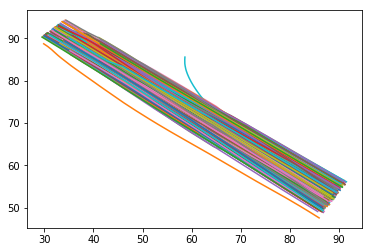

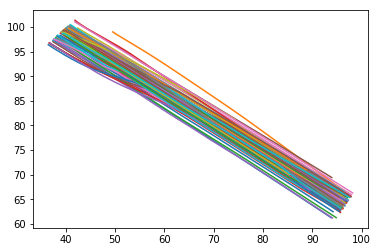

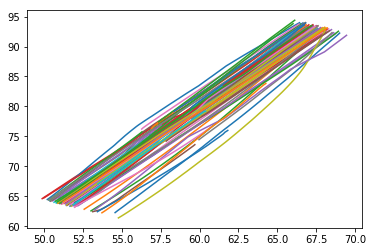

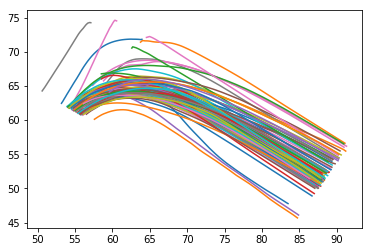

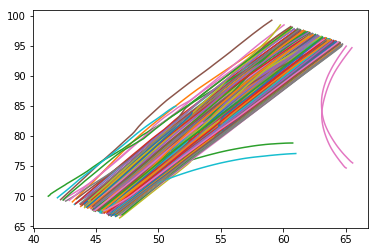

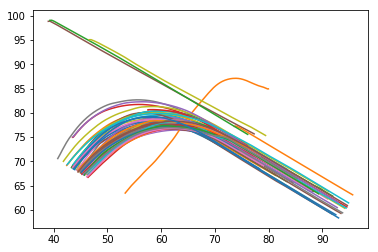

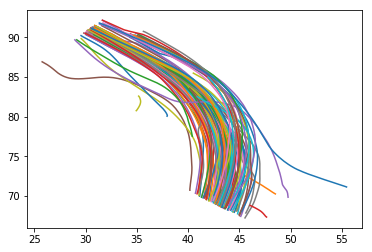

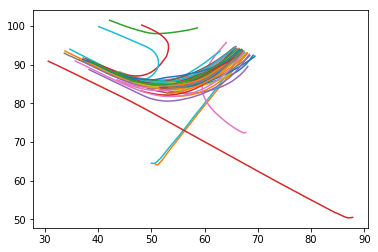

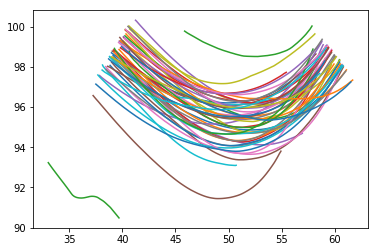

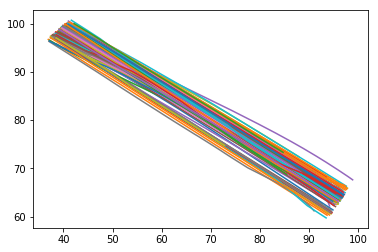

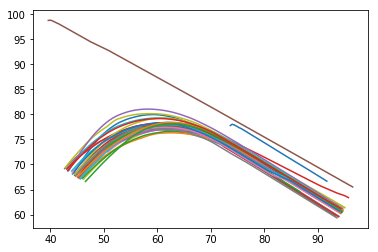

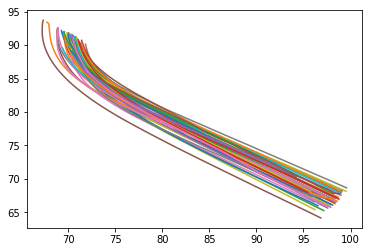

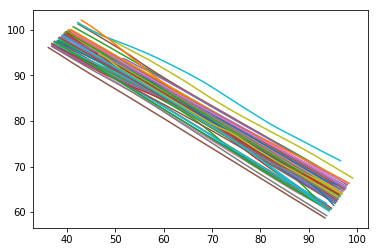

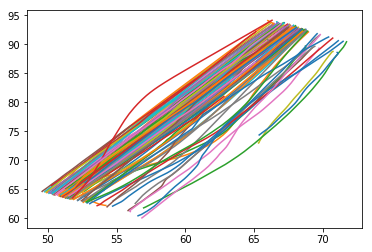

In [5]:
m = np.max(X_targets)
for i in range(m+1):
    traj = []
    for j,c in enumerate(X_targets):
        if c == i:
            traj.append(trajectories[j])
    ut.refactor_and_plot(traj)

### Separate features between train and test set

In [6]:
test_prop = 0.2
ids_train, ids_test = train_test_split(np.arange(len(trajectories)), test_size = test_prop)

X_train_trajectories = trajectories[ids_train]
X_train_velocities = X_velocities[ids_train]
X_train_targets = X_targets[ids_train]

X_test_trajectories = trajectories[ids_test]
X_test_velocities = X_velocities[ids_test]
X_test_targets = X_targets[ids_test]

### CLustering on starting points to learn the different categories of starting points

In [7]:
#ex = ids[ids_test]
#ids_for_point = []
#for i in range(len(trajectories_o)):
 #   if i not in ex:
  #      ids_for_point.append(i)

In [8]:
points_data,points,nb_points = test.get_first_points_data(X_train_trajectories, X_train_velocities )
#points_data,points,nb_points = test.get_first_points_data(trajectories_o[ids_for_point], velocities_o[ids_for_point] )

In [9]:
nb_points

1129

In [10]:
points

array([[96.5476, 63.0814],
       [90.5716, 29.9427],
       [96.5676, 62.3823],
       ...,
       [64.8683, 50.5421],
       [82.1959, 52.3656],
       [85.9923, 41.2722]])

#### Apply standardization and PCA for starting points clustering

In [11]:
#points_data_std_pca,scaler_points,pca_points = test.standardize_and_reduce_dimensions(points_data)
points_data_std_pca,scaler_points,pca_points = test.standardize_and_reduce_dimensions(points)

nb_components: 2


optimal numbers of clusters: [4, 12, 23]


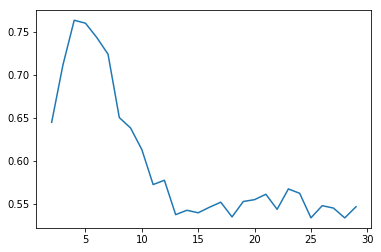

In [12]:
max_clusters = 30
nb_clusters = test.get_optimal_cluster_number(max_clusters,points_data_std_pca,KMeans(),True)

In [13]:
#nb_clusters = 10

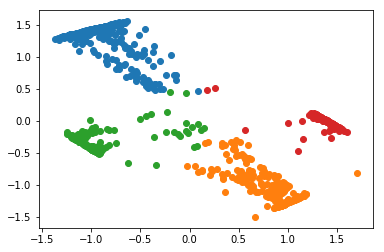

In [14]:
point_targets,clusterer = test.plot_points_clusters(nb_clusters,KMeans(),points_data_std_pca,points)

### Train point classifier

#### Get train and test sets

In [15]:
point_test_prop = 0.20
#ids_train, ids_test, [points_data_train,point_targets_train], [points_data_test,point_targets_test ] = test.split_train_test(nb_points,[points_data,point_targets], point_test_prop)
ids_train, ids_test, [points_data_train,point_targets_train], [points_data_test,point_targets_test ] = test.split_train_test(nb_points,[points,point_targets], point_test_prop)

#### get standardization and pca from  training set

In [16]:
points_data_train_std_pca,scaler_point_class,pca_point_class = test.standardize_and_reduce_dimensions(points_data_train)

nb_components: 2


Then apply them on the test set

In [17]:
points_data_test_std = scaler_point_class.transform(points_data_test)
points_data_test_std_pca = pca_point_class.transform(points_data_test_std)

##### Train point classifier

In [18]:
point_classifier = LogisticRegression(multi_class = "multinomial", solver = "newton-cg")
point_classifier.fit(points_data_train_std_pca,point_targets_train)
train_point_pred = point_classifier.predict(points_data_train_std_pca)
test_point_pred = point_classifier.predict(points_data_test_std_pca)

###### Performance results

In [19]:
print("train error: " + str(f1_score(point_targets_train,train_point_pred,average = "micro")))
print("test error: " + str(f1_score(point_targets_test,test_point_pred,average = "micro")))

train error: 0.9955703211517165
test error: 0.9867256637168141


##### retrain classifier on the whole dataset

In [20]:
#points_data_std = scaler_point_class.fit_transform(points_data)
points_data_std = scaler_point_class.fit_transform(points)
points_data_std_pca = pca_point_class.fit_transform(points_data_std)
point_classifier = point_classifier.fit(points_data_std_pca,point_targets)
point_pred = point_classifier.predict(points_data_std_pca)

# Train partial trajectory classifier

To learn how to classify a subtrajectory, the features will be the starting point class (as a binary representation) and stats on the subtrajectory

## Random subtrajectories extraction

For each trajectory in the training set, for a defined number of sub trajectory per trajectory, we pick a subtrajectory whose size is randomly pick between 3 and the minimum trajectory length of the trajectory

In [21]:
point_targets

array([3, 1, 3, ..., 2, 1, 1], dtype=int32)

In [22]:
point_pred

array([3, 1, 3, ..., 2, 1, 1], dtype=int32)

In [23]:
X_sub_trajectories,X_sub_velocities,X_sub_targets,X_sub_point_targets = test.extract_subtrajectories(X_train_trajectories,X_train_velocities,X_train_targets,point_targets,10,3)

### Get train and test set for trajectory classification

In [24]:
to_split = [X_sub_trajectories,X_sub_velocities,X_sub_targets,X_sub_point_targets]

ids_train, ids_test, trains, tests = test.split_train_test(len(X_sub_trajectories),to_split, point_test_prop)

[X_train_sub_trajectories,X_train_sub_velocities,X_train_sub_targets,X_train_sub_point_targets] = trains
[X_test_sub_trajectories,X_test_sub_velocities,X_test_sub_targets,X_test_sub_point_targets] = tests

### Compute features and normalize

In [25]:
X_train_sub_features = [ft.compute_features(trajectory,velocity) for trajectory,velocity in zip(X_train_sub_trajectories,X_train_sub_velocities)]
X_train_sub_features_std,trajectory_train_stder = ft.standardize_features(X_train_sub_features)
X_train_sub_features_std = pd.DataFrame(X_train_sub_features_std)

##### use the same standardizer fit with train for test

In [26]:
X_test_sub_features = [ft.compute_features(trajectory,velocity) for trajectory,velocity in zip(X_test_sub_trajectories,X_test_sub_velocities)]
X_test_sub_features_std,_ = ft.standardize_features(X_test_sub_features,trajectory_train_stder)
X_test_sub_features_std = pd.DataFrame(X_test_sub_features_std)

### one hot encode the subtrajectory starting point class

In [27]:
ohe_train_trajectory = OneHotEncoder(sparse = False, dtype=np.int)

one_hot_train_startpoint_class = pd.DataFrame(ohe_train_trajectory.fit_transform(X_train_sub_point_targets.reshape(-1,1)))
one_hot_test_startpoint_class = pd.DataFrame(ohe_train_trajectory.transform(X_test_sub_point_targets.reshape(-1,1)))

In [28]:
X_train = pd.concat([one_hot_train_startpoint_class,X_train_sub_features_std], axis=1)
y_train = X_train_sub_targets

In [29]:
X_test = pd.concat([one_hot_test_startpoint_class,X_test_sub_features_std], axis=1)
y_test = X_test_sub_targets

#### Apply pca

In [30]:
pca_train_class_traj = PCA(n_components=0.99)
X_train_pca = pca_train_class_traj.fit_transform(X_train)
X_test_pca = pca_train_class_traj.transform(X_test)
pca_train_class_traj.n_components_

20

### Train classifier

In [31]:
subtrajectory_classifier = LogisticRegression(multi_class = "multinomial", solver = "newton-cg")
subtrajectory_classifier.fit(X_train_pca,y_train)
train_pred = subtrajectory_classifier.predict(X_train_pca)
test_pred = subtrajectory_classifier.predict(X_test_pca)

#### classification performances

In [32]:
print("train error: " + str(f1_score(X_train_sub_targets,train_pred,average = "micro")))
print("test error: " + str(f1_score(X_test_sub_targets,test_pred,average = "micro")))

train error: 0.9878183831672204
test error: 0.9808259587020649


In [33]:
m = confusion_matrix(X_test_sub_targets,test_pred)

In [34]:
m

array([[118,   0,   0,   0,   0,   0,   2,   0,   0,   0,   0,   0,   0,
          0],
       [  0,  34,   0,   0,   0,   0,   0,   0,   0,   2,   1,   0,   1,
          0],
       [  0,   0,  39,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          1],
       [  0,   0,   0,  41,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          1],
       [  0,   0,   0,   0,  82,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [  0,   0,   0,   0,   0,  24,   0,   0,   0,   0,   0,   0,   1,
          0],
       [  0,   0,   0,   0,   0,   0,  60,   0,   0,   0,   0,   0,   0,
          0],
       [  0,   0,   0,   0,   0,   0,   0,  37,   0,   0,   0,   0,   0,
          0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  24,   0,   0,   0,   0,
          0],
       [  0,   3,   0,   0,   0,   0,   0,   0,   0,  64,   0,   0,   0,
          0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  24,   0,   0,
          0],
       [  0,   0,   0,   0,   0,   0,   0, 

#### retrain on the whole dataset

In [35]:
ohe_trajectory = OneHotEncoder(sparse = False, dtype=np.int)
one_hot_startpoint_class = pd.DataFrame(ohe_trajectory.fit_transform(X_sub_point_targets.reshape(-1,1)))

#X_sub_features = [ft.compute_features(trajectory,velocity) for trajectory,velocity in zip(X_sub_trajectories,X_sub_velocities)]
X_sub_features = X_train_sub_features + X_test_sub_features
X_sub_features_std,trajectory_stder = ft.standardize_features(X_sub_features)
X_sub_features_std = pd.DataFrame(X_sub_features_std)

X = pd.concat([one_hot_startpoint_class,X_sub_features_std], axis=1)
y = X_sub_targets

pca_class_traj = PCA(n_components=0.99)
X_pca = pca_class_traj.fit_transform(X)
X_pca = pd.DataFrame(X_pca)

In [36]:
subtrajectory_classifier.fit(X_pca,y)
#trajectories_pred = subtrajectory_classifier.predict(X_pca)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

# Apply on unseen trajectories

In [37]:
#points_data_std = scaler_point_class.fit_transform(points)
#points_data_std_pca = pca_point_class.fit_transform(points_data_std)
#point_classifier = point_classifier.fit(points_data_std_pca,point_targets)
#point_pred = point_classifier.predict(points_data_std_pca)

In [38]:
points_data_test,points_test,nb_points_test = test.get_first_points_data(X_test_trajectories, X_test_velocities )

In [39]:
#points_data_std_test = scaler_point_class.transform(points_data_test)
points_data_std_test = scaler_point_class.transform(points_test)
points_data_std_pca_test = pca_point_class.transform(points_data_std_test)
point_targets_test = point_classifier.predict(points_data_std_pca_test)

In [54]:
p = scaler_points.transform(points_test)
p = pca_points.transform(p)
targets = clusterer.predict(p)

In [55]:
targets

array([0, 2, 0, 1, 0, 3, 1, 1, 2, 3, 0, 0, 3, 1, 0, 0, 0, 0, 1, 1, 0, 3,
       2, 0, 0, 2, 0, 1, 0, 2, 0, 1, 3, 0, 0, 3, 2, 1, 1, 1, 1, 1, 2, 1,
       0, 0, 0, 3, 1, 2, 1, 1, 1, 0, 2, 0, 3, 0, 0, 0, 2, 3, 3, 3, 0, 1,
       0, 3, 0, 2, 2, 3, 0, 2, 1, 0, 3, 3, 3, 0, 1, 3, 3, 0, 2, 3, 3, 0,
       2, 0, 1, 2, 2, 3, 0, 1, 0, 1, 1, 0, 2, 1, 0, 2, 2, 1, 1, 0, 0, 3,
       1, 2, 0, 1, 0, 1, 0, 3, 1, 2, 2, 2, 3, 2, 0, 0, 2, 1, 2, 3, 1, 3,
       1, 0, 2, 1, 2, 1, 0, 2, 1, 1, 0, 0, 3, 0, 2, 1, 1, 2, 2, 2, 3, 2,
       3, 3, 1, 1, 2, 3, 0, 2, 0, 3, 0, 0, 0, 1, 1, 1, 3, 3, 1, 3, 2, 0,
       0, 0, 1, 0, 0, 0, 3, 1, 2, 1, 1, 2, 1, 2, 0, 1, 3, 1, 0, 0, 3, 0,
       0, 3, 1, 1, 0, 1, 2, 0, 0, 2, 0, 0, 0, 0, 0, 1, 3, 1, 0, 1, 0, 2,
       0, 1, 2, 1, 1, 1, 2, 0, 0, 1, 1, 0, 0, 0, 0, 3, 1, 2, 1, 2, 3, 1,
       3, 2, 2, 2, 1, 1, 0, 1, 3, 0, 0, 0, 1, 2, 1, 2, 1, 3, 3, 0, 0, 1,
       2, 0, 0, 2, 0, 1, 1, 0, 1, 1, 0, 3, 0, 2, 1, 0, 2, 3, 1],
      dtype=int32)

In [56]:
point_targets_test = targets

In [57]:
X_sub_trajectories_test,X_sub_velocities_test,X_sub_targets_test,X_sub_point_targets_test = test.extract_subtrajectories(X_test_trajectories,X_test_velocities,X_test_targets,point_targets_test,10,3)

In [58]:
one_hot_startpoint_class_test = pd.DataFrame(ohe_trajectory.transform(X_sub_point_targets_test.reshape(-1,1)))

In [59]:
one_hot_startpoint_class_test

,0,1,2,3
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,0,0,1,0
4,0,0,1,0
5,0,0,1,0
6,1,0,0,0
7,1,0,0,0
8,1,0,0,0
9,0,1,0,0


In [60]:
X_sub_features_test = [ft.compute_features(trajectory,velocity) for trajectory,velocity in zip(X_sub_trajectories_test,X_sub_velocities_test)]
X_sub_features_std_test,_ = ft.standardize_features(X_sub_features_test,trajectory_stder)
X_sub_features_std_test = pd.DataFrame(X_sub_features_std_test)

In [61]:
X_test = pd.concat([one_hot_startpoint_class_test,X_sub_features_std_test], axis=1)
y_test = X_sub_targets_test

X_test_pca = pca_class_traj.transform(X_test)
X_test_pca = pd.DataFrame(X_test_pca)

In [62]:
final_pred = subtrajectory_classifier.predict(X_test_pca)

In [63]:
print("test error: " + str(f1_score(y_test,final_pred,average = "micro")))

test error: 0.5123674911660777


In [64]:
print("test error: " + str(f1_score(y_test,final_pred,average = None)))

test error: [0.76020408 0.         0.         0.4957265  0.83516484 0.
 0.08695652 0.         0.         0.46612466 0.         0.
 0.         0.69230769]


In [65]:
from sklearn.metrics import confusion_matrix

m = confusion_matrix(y_test,final_pred)

In [66]:
tot = []
for i in range(14):
    sum_ = 0
    for t in X_test_targets:
        if t == i:
            sum_ += 1
    tot.append(float(sum_)/len(X_test_targets))

In [67]:
print(m)

[[149   0   0   0   0   0   0   1   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  73   0   5   0   0]
 [  0   0   0  28   0   0   0   0   0   0   0   0   0  23]
 [  0   0   3  29   0   0   0   0   0   0   0   0   0   1]
 [  9   0   0   3 114   0   0   0   0   0   0   0   0   3]
 [  0   0   0   3   0   0   0   0   0  27   0   0   0   0]
 [ 60   0   0   0   0   0   3   0   0   0   0   0   0   3]
 [ 24   0   0   3   3   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  27   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   1   0  86   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  36   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  21   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  39   0   0   0   0]
 [  0   0   0  18   0   0   0   0   0   0   0   0   0  54]]


# Conclusion:

Les résultats ne sont pas très bons, mais ils sont meilleurs que si on utilisait un classificateur donnant toujours la même classe, ou un classificateur aléatoire.

Peut être amélioré en :

    Nettoyant les données
    
    Réduisant de fait le nombre de clusters
    
    Effectuant du stratified kfold
    
    Utiliser techniques d'ensemble pour la classification
    